# ex34-Correlations between SOI and SLP, Temperature and Precipitation

This tutorial will reproduce and extend the [NCL:Correlations example](https://www.ncl.ucar.edu/Applications/Scripts/indices_soi_2.ncl) with python packages.

- Read gridded sea level pressure from the 20th Century Reanalysis 
- use proxy grid points near Tahiti and Darwin to construct an SOI time series spanning 1950-2018
- perform lag-0 correlations between
 - SOI and SLP
 - SOI and temperature
 - SOI and preciptation using GPCP data which spans 1979-2018.
 
 In addtion, the significane level of (p<0.01) was dotted on the correlation maps.

In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
import pandas as pd
from numba import jit
from functools import partial
from scipy.stats import pearsonr

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set some parameters to apply to all plots. These can be overridden
import matplotlib
# Plot size to 12" x 7"
matplotlib.rc('figure', figsize = (15, 7))
# Font size to 14
matplotlib.rc('font', size = 14)
# Do not display top and right frame lines
matplotlib.rc('axes.spines', top = True, right = True)
# Remove grid lines
matplotlib.rc('axes', grid = False)
# Set backgound color to white
matplotlib.rc('axes', facecolor = 'white')

## 1. Basic information

***Data files***

All of these data are publicly available from [NCEP/NCAR Reanalysis 1](https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.html) and [GPCP Version 2.3 Combined Precipitation Data Set](https://www.esrl.noaa.gov/psd/data/gridded/data.gpcp.html)

In [3]:
filslp = "data/prmsl.mon.mean.nc"
filtmp = "data/air.sig995.mon.mean.nc"
filprc = "data/precip.mon.mean.nc"

***Specification for reference years***

In [4]:
yrStrt  = 1950          # manually specify for convenience
yrLast  = 2018          # 20th century ends 2018  

clStrt  = 1950          # reference climatology for SOI
clLast  = 1979          

yrStrtP = 1979          # 1st year GPCP
yrLastP = yrLast        # match 20th century

***Grid points near Tahiti and Darwin***

These two points are used to construct an SOI time series spanning 1950-2018.

In [5]:
latT = -17.6         # Tahiti
lonT = 210.75  
latD = -12.5         # Darwin 
lonD = 130.83  

## 2. Calculate SOI Index

In [22]:
# read slp data
ds_slp = xr.open_dataset(filslp).sel(time=slice(str(yrStrt)+'-01-01', str(yrLast)+'-12-31'))

# select grids of T and D
T    = ds_slp.sel(lat=latT, lon=lonT, method='nearest')
D    = ds_slp.sel(lat=latD, lon=lonD, method='nearest')

# monthly reference climatologies
TClm = T.sel(time=slice(str(clStrt)+'-01-01', str(clLast)+'-12-31'))     
DClm = D.sel(time=slice(str(clStrt)+'-01-01', str(clLast)+'-12-31'))

# anomalies reference clim
TAnom = T.groupby('time.month') - TClm.groupby('time.month').mean('time')
DAnom = D.groupby('time.month') - DClm.groupby('time.month').mean('time')

# stddev of anomalies over clStrt & clLast
TAnomStd   = np.std(TAnom.sel(time=slice(str(clStrt)+'-01-01', str(clLast)+'-12-31'))) 
DAnomStd   = np.std(DAnom.sel(time=slice(str(clStrt)+'-01-01', str(clLast)+'-12-31')))

# signal and noise
soi_signal = ((TAnom/TAnomStd) - (DAnom/DAnomStd)).rename({'slp':'SOI'}) 

## 3. lag-0 correlation

At present, I have not found a good way to return multiple xarray.dataarray from xarray.apply_ufunc(). 

Therefore, I have to calculate Pearson correlation twice, which waste half a time.

### 3.1 Functions to calculate Pearson correlation

In [7]:
@jit(nogil=True)
def pr_cor_corr(x, y):
    """
    Uses the scipy stats module to calculate a pearson correlation test
    :x vector: Input pixel vector to run tests on
    :y vector: The date input vector 
    """
    # Check NA values
    co = np.count_nonzero(~np.isnan(x))
    if co < len(y): # If fewer than length of y observations return np.nan
        print('I am here')
        return np.nan, np.nan   
    
    corr, _ = pearsonr(x, y)
    return corr

@jit(nogil=True)
def pr_cor_pval(x, y):
    """
    Uses the scipy stats module to calculate a pearson correlation test
    :x vector: Input pixel vector to run tests on
    :y vector: The date input vector 
    """
    # Check NA values
    co = np.count_nonzero(~np.isnan(x))
    if co < len(y): # If fewer than length of y observations return np.nan
        return np.nan
    # Run the pearson correlation test
    _, p_value = pearsonr(x, y)
    return p_value   

# The function we are going to use for applying our pearson test per pixel
def pearsonr_corr(x, y, func=pr_cor_corr, dim='time'):
    # x = Pixel value, y = a vector containing the date, dim == dimension
    return xr.apply_ufunc(
        func, x , y,
        input_core_dims=[[dim], [dim]],        
        vectorize=True,   
        output_dtypes=[float]
    )

### 3.2 Calculate lag-0 correlation between SOI and (slp, temperature, precipitation), respectively

In [8]:
ds_tmp  = xr.open_dataset(filtmp).sel(time=slice(str(yrStrt)+'-01-01', str(yrLast)+'-12-31'))
ds_prc   = xr.open_dataset(filprc).sel(time=slice(str(yrStrtP)+'-01-01', str(yrLastP)+'-12-31'))

# slp
da_slp   = ds_slp.slp.stack(point=('lat', 'lon')).groupby('point')
slp_corr = pearsonr_corr(da_slp, soi_signal.SOI).unstack('point')
slp_pval = pearsonr_corr(da_slp, soi_signal.SOI, func= pr_cor_pval).unstack('point')

# tmp
da_tmp   = ds_tmp.air.stack(point=('lat', 'lon')).groupby('point')
tmp_corr = pearsonr_corr(da_tmp, soi_signal.SOI).unstack('point')
tmp_pval = pearsonr_corr(da_tmp, soi_signal.SOI, func= pr_cor_pval).unstack('point')

# prc
soi_prc  = soi_signal.sel(time=slice(str(yrStrtP)+'-01-01', str(yrLastP)+'-12-31'))
da_prc   = ds_prc.precip.stack(point=('lat', 'lon')).groupby('point')
prc_corr = pearsonr_corr(da_prc, soi_prc.SOI).unstack('point')
prc_pval = pearsonr_corr(da_prc, soi_prc.SOI, func= pr_cor_pval).unstack('point')

## 4. Visualization

### 4.1 SOI

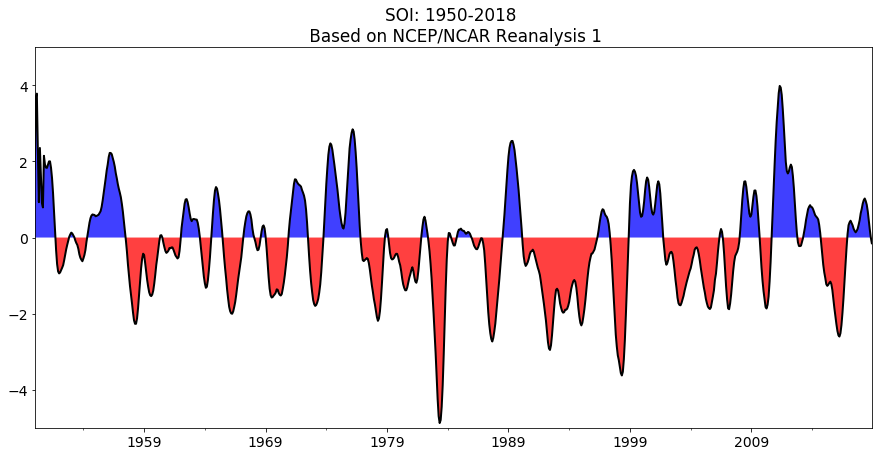

In [21]:
# Convert to pandas.dataframe
df_soi = soi_signal.to_dataframe().drop('month', axis=1)

# 11-point smoother: Use reflective boundaries to fill out plot 
window  = 11
weights = [0.0270, 0.05856, 0.09030, 0.11742, 0.13567, 
           0.1421, 0.13567, 0.11742, 0.09030, 0.05856, 
           0.027]
ewma = partial(np.average, weights=weights)
rave = df_soi.rolling(window).apply(ewma).fillna(df_soi)

fig, ax = plt.subplots()
rave.plot(ax=ax, color='black', alpha=1.00, linewidth=2, legend=False)
d = rave.index
ax.fill_between(d, 0, rave['SOI'],
                where=rave['SOI'] >0,
                facecolor='blue', alpha=0.75, interpolate=True)

ax.fill_between(d, 0, rave['SOI'],
                where=rave['SOI']<0,
                facecolor='red', alpha=0.75, interpolate=True)

_ = ax.set_ylim(-5, 5)
_ = ax.set_title('SOI: %s-%s \n Based on NCEP/NCAR Reanalysis 1' %(str(yrStrt), str(yrLast)))
_ = ax.set_xlabel('')

### 4.2 Correlations maps

#### 4.2.1 SOI vs. SLP

***Mask correlation with pvalues***

ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
slp_corr.where(slp_pval < 0.01).plot(ax=ax, cmap='RdYlBu_r', transform=ccrs.PlateCarree())

ax.set_title('SOI SLP')
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)

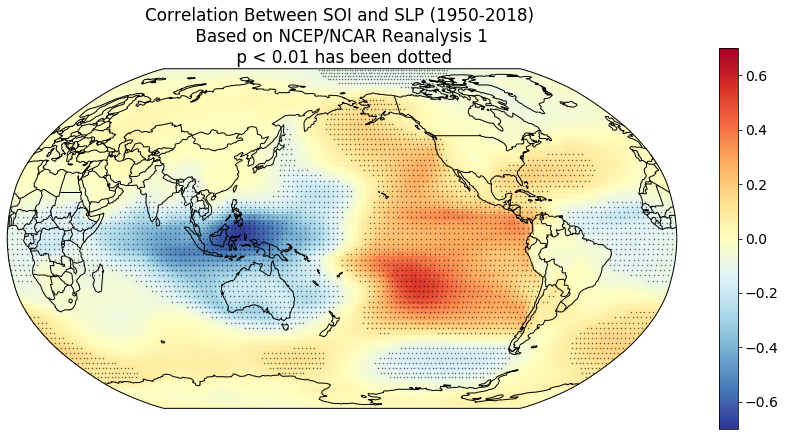

In [18]:
lons, lats = np.meshgrid(slp_corr.lon, slp_corr.lat)
sig_area   = np.where(slp_pval < 0.01)

ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
slp_corr.plot(ax=ax, vmax=0.7, vmin=-0.7, cmap='RdYlBu_r', transform=ccrs.PlateCarree())
_ = ax.scatter(lons[sig_area], lats[sig_area], marker = '.', s = 1, c = 'k', alpha = 0.6, transform = ccrs.PlateCarree())

ax.set_title('Correlation Between SOI and SLP (%s-%s) \n Based on NCEP/NCAR Reanalysis 1 \n p < 0.01 has been dotted' %(str(yrStrt), str(yrLast)))
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)

#### 4.2.2 SOI vs. TMP

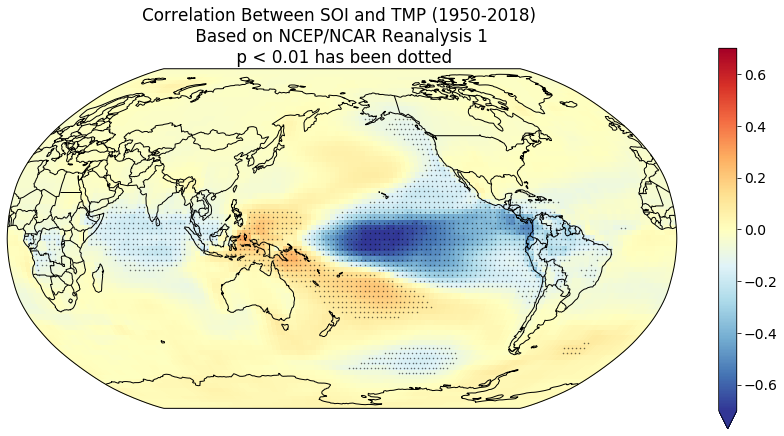

In [19]:
lons, lats = np.meshgrid(tmp_corr.lon, tmp_corr.lat)
sig_area   = np.where(tmp_pval < 0.01)

ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
tmp_corr.plot(ax=ax, vmax=0.7, vmin=-0.7, cmap='RdYlBu_r', transform=ccrs.PlateCarree())
_ = ax.scatter(lons[sig_area], lats[sig_area], marker = '.', s = 1, c = 'k', alpha = 0.6, transform = ccrs.PlateCarree())

ax.set_title('Correlation Between SOI and TMP (%s-%s) \n Based on NCEP/NCAR Reanalysis 1 \n p < 0.01 has been dotted' %(str(yrStrt), str(yrLast)))
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)

#### 4.2.3 SOI vs. PRC

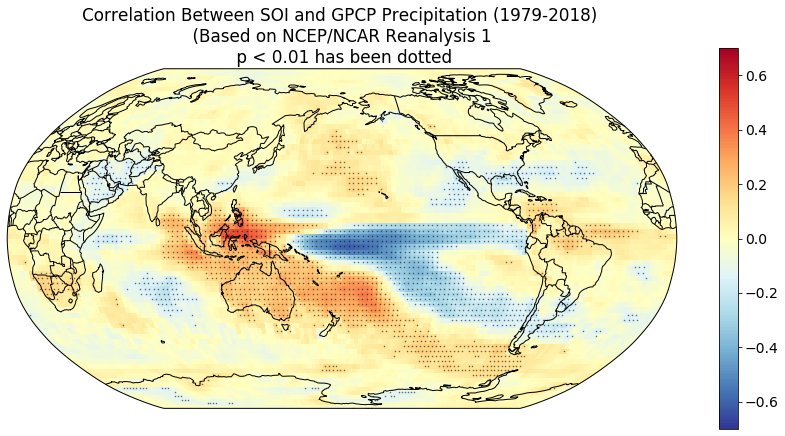

In [20]:
lons, lats = np.meshgrid(prc_corr.lon, prc_corr.lat)
sig_area   = np.where(prc_pval < 0.01)

ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
prc_corr.plot(ax=ax, vmax=0.7, vmin=-0.7, cmap='RdYlBu_r', transform=ccrs.PlateCarree())
_ = ax.scatter(lons[sig_area], lats[sig_area], marker = '.', s = 1, c = 'k', alpha = 0.6, transform = ccrs.PlateCarree())

ax.set_title('Correlation Between SOI and GPCP Precipitation (%s-%s) \n (Based on NCEP/NCAR Reanalysis 1 \n p < 0.01 has been dotted' %(str(yrStrtP), str(yrLastP)))
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)

## References

For dataset source, please cite:Kalnay et al.,The NCEP/NCAR 40-year reanalysis project, Bull. Amer. Meteor. Soc., 77, 437-470, 1996.

Adler, R.F., G.J. Huffman, A. Chang, R. Ferraro, P. Xie, J. Janowiak, B. Rudolf, U. Schneider, S. Curtis, D. Bolvin, A. Gruber, J. Susskind, and P. Arkin, 2003: The Version 2 Global Precipitation Climatology Project (GPCP) Monthly Precipitation Analysis (1979-Present). J. Hydrometeor., 4,1147-1167.

Jones E, Oliphant E, Peterson P, et al. SciPy: Open Source Scientific Tools for Python, 2001-, http://www.scipy.org/ [Online; accessed 2019-10-14].

Travis E, Oliphant. A guide to NumPy, USA: Trelgol Publishing, (2006).

Stéfan van der Walt, S. Chris Colbert and Gaël Varoquaux. The NumPy Array: A Structure for Efficient Numerical Computation, Computing in Science & Engineering, 13, 22-30 (2011), DOI:10.1109/MCSE.2011.37 

Fernando Pérez and Brian E. Granger. IPython: A System for Interactive Scientific Computing, Computing in Science & Engineering, 9, 21-29 (2007), DOI:10.1109/MCSE.2007.53

John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007), DOI:10.1109/MCSE.2007.55

Wes McKinney. Data Structures for Statistical Computing in Python, Proceedings of the 9th Python in Science Conference, 51-56 (2010)

https://www.ncl.ucar.edu/Applications/corel.shtml